In [1]:
#preset weights and values 
#trial one start stimulus and reward at time t (t=100, u=1; t=200, r=2, delta = 2)
#update delta using td learning rule and weights accordingly (u(t-tau)=1, tau = 100, t=200). Loop tau through t
#Don't use learning rates too small 
#second loop: at t=199, v(t+1) = 0.2 (expect reward at t=200)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.ndimage import gaussian_filter
from matplotlib import cm
import random
import copy

In [3]:
#Params
time_vector = np.arange(0,220)
trials = 350
stim = np.zeros((len(time_vector)))
stim[99] = 1
alpha = 0.5 #learning rate
reward = np.zeros(len(time_vector))
#start_gauss, end_gauss, stdev = 190, 210, np.sqrt(2/np.pi) #such that area = 2
#window = gaussian(end_gauss - start_gauss, std=stdev)
#window /= np.sum(window)
#reward[start_gauss:end_gauss] = window*2
reward[200] = 2
reward = gaussian_filter(reward,2)

In [4]:
#Basic TD learning
weights = np.zeros((trials,len(time_vector)))
values_plot = np.zeros((trials,len(time_vector)))
values = np.zeros(len(time_vector)) #Prediction
delta = np.zeros((trials,len(time_vector))) #Prediction error
for i in tqdm.tqdm(range(trials)):
    for t in range(len(time_vector)-1): #Ignore the last array as it is 0 anyway
        for tau in range(t):
                values[t] = values[t] + weights[i-1,tau]*stim[t-tau]
        delta[i,t] = reward[t] - values[t] + values[t+1] #RPE
        for tau in range(t+1):
            weights[i,tau] = weights[i,tau] + alpha*delta[i,t]*stim[t-tau]
    values_plot[i] = values


  0%|          | 0/350 [00:00<?, ?it/s]

100%|██████████| 350/350 [00:45<00:00,  7.72it/s]


In [5]:
delta_v = np.zeros((2, len(time_vector)-1))
delta_v[0] = np.diff(values_plot[0])
delta_v[1] = np.diff(values_plot[-1])

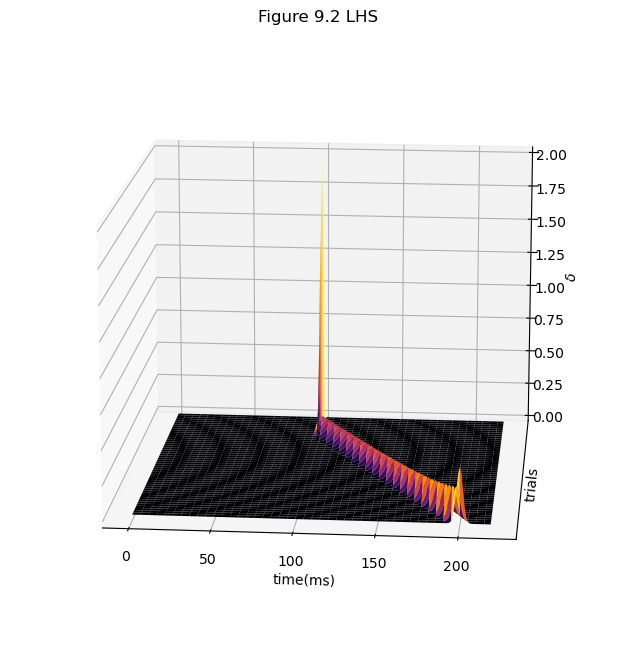

In [6]:
#Plot 9.2 LHS
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8,8))
X = time_vector
Y = np.arange(0,trials)
X, Y = np.meshgrid(time_vector, np.arange(0, trials))
Z = delta
surf = ax.plot_surface(X,Y,Z,cmap=cm.inferno)
ax.view_init(elev=15, azim=-85) 
ax.set_xlabel("time(ms)")
ax.set_ylabel("trials",labelpad=-15)
ax.set_yticks([])
ax.set_zlabel("$\delta$")
ax.set_zlim(0,2)
ax.set_title("Figure 9.2 LHS")
plt.show()




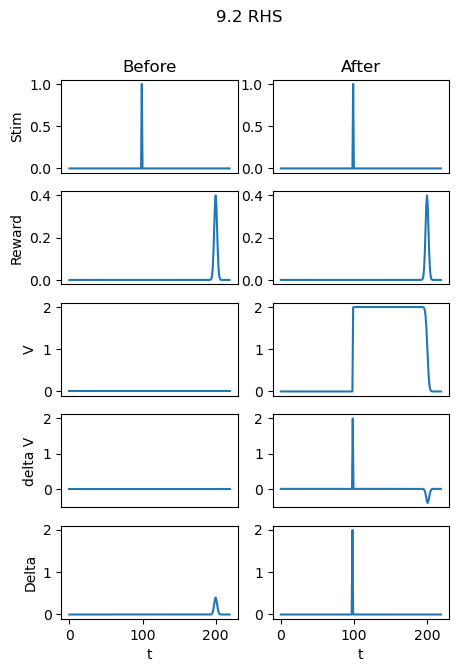

In [7]:
#Figure 9.2B 

fig, ax = plt.subplots(5,2,figsize=(5,7))
fig.suptitle('9.2 RHS')
ax[0,0].set_title("Before")
ax[0,1].set_title("After")
ax[0,0].plot(stim)
ax[0,0].set_ylabel("Stim")
ax[0,1].plot(stim)
ax[1,0].plot(reward)
ax[1,0].set_ylabel("Reward")
ax[1,1].plot(reward)
ax[2,0].set_ylabel("V")
ax[2,0].plot(values_plot[0])
ax[2,1].plot(values_plot[-1])
ax[2,0].set_ylim(ax[2, 1].get_ylim())
ax[3,0].set_ylabel("delta V")
ax[3,0].plot(delta_v[0])
ax[3,1].plot(delta_v[1])
ax[3,0].set_ylim(ax[3, 1].get_ylim())
ax[4,0].set_ylabel("Delta")
ax[4,0].plot(delta[0])
ax[4,0].set_xlabel("t")
ax[4,1].plot(delta[-1])
ax[4,1].set_xlabel("t")
ax[4,0].set_ylim(ax[4, 1].get_ylim())
for i in range(4):
    for col in range(2):
        ax[i,col].set_xticks([])
    

Experiment with timing/learning rates/multiple rewards/stochastic rewards/etc

In [47]:
#Timing
timings = np.linspace(10,90,9)
all_delta_t = np.zeros((len(timings),trials,len(time_vector)))
for j, times in tqdm.tqdm(enumerate(timings)):
    weights_t = np.zeros((trials,len(time_vector))) #Reset for the next learning rate
    values_t = np.zeros(len(time_vector))
    delta_t = np.zeros((trials,len(time_vector)))
    reward_t = np.zeros(len(reward))
    reward_t[int(np.where(stim!=0)+times)] = 2 #110, 120, 130...
    reward_t = gaussian_filter(reward_t,2)
    for i in range(trials):
        for t in range(len(time_vector)-1): #Ignore the last array
            for tau in range(t):
                    values_t[t] = values_t[t] + weights_t[i-1,tau]*stim[t-tau]
            delta_t[i,t] = reward_t[t] - values_t[t] + values_t[t+1] #RPE
            for tau in range(t+1):
                weights_t[i,tau] = weights_t[i,tau] + alpha*delta_t[i,t]*stim[t-tau]
    all_delta_t[j] = delta_t

9it [03:40, 24.45s/it]


100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


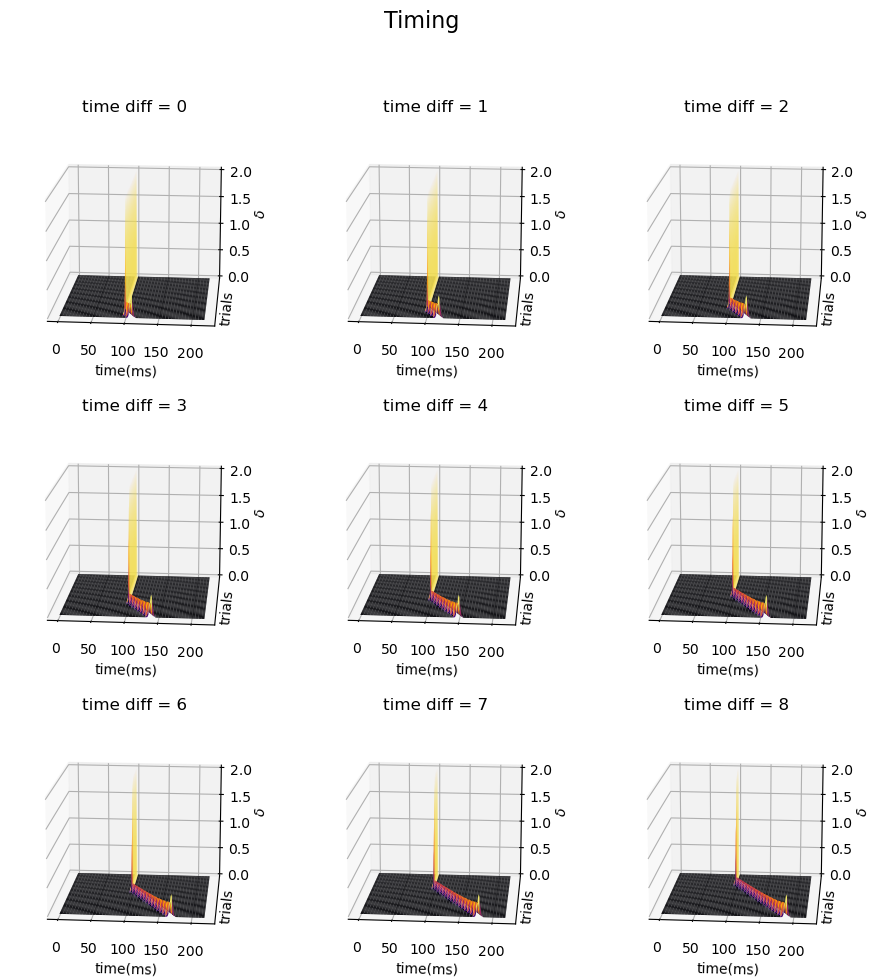

In [53]:
fig, axes = plt.subplots(3,3, subplot_kw={"projection": "3d"}, figsize=(11,11))
fig.suptitle('Timing', fontsize=16)
for times in tqdm.tqdm(range(len(timings))):
    ax = axes.flatten()[times]
    X, Y = np.meshgrid(time_vector, np.arange(0, trials))
    Z = all_delta_t[times]
    surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno)
    ax.set_xlabel("time(ms)")
    ax.set_ylabel("trials",labelpad=-15)
    ax.set_yticks([])
    ax.set_zlabel("$\delta$")
    ax.set_zlim(0, 2)
    ax.view_init(elev=15, azim=-85)
    ax.set_title(f'time diff = {times}')

In [8]:
#Learning rate
LRs = np.linspace(0.1,1,10)
all_delta = np.zeros((len(LRs),trials,len(time_vector)))
for j,LR in tqdm.tqdm(enumerate(LRs)):
    weights_LR = np.zeros((trials,len(time_vector))) #Reset for the next learning rate
    values_LR = np.zeros(len(time_vector))
    delta_LR = np.zeros((trials,len(time_vector)))
    for i in range(trials):
        for t in range(len(time_vector)-1): #Ignore the last array
            for tau in range(t):
                    values_LR[t] = values_LR[t] + weights_LR[i-1,tau]*stim[t-tau]
            delta_LR[i,t] = reward[t] - values_LR[t] + values_LR[t+1] #RPE
            for tau in range(t+1):
                weights_LR[i,tau] = weights_LR[i,tau] + LR*delta_LR[i,t]*stim[t-tau]
    all_delta[j] = delta_LR
    


10it [05:31, 33.19s/it]


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


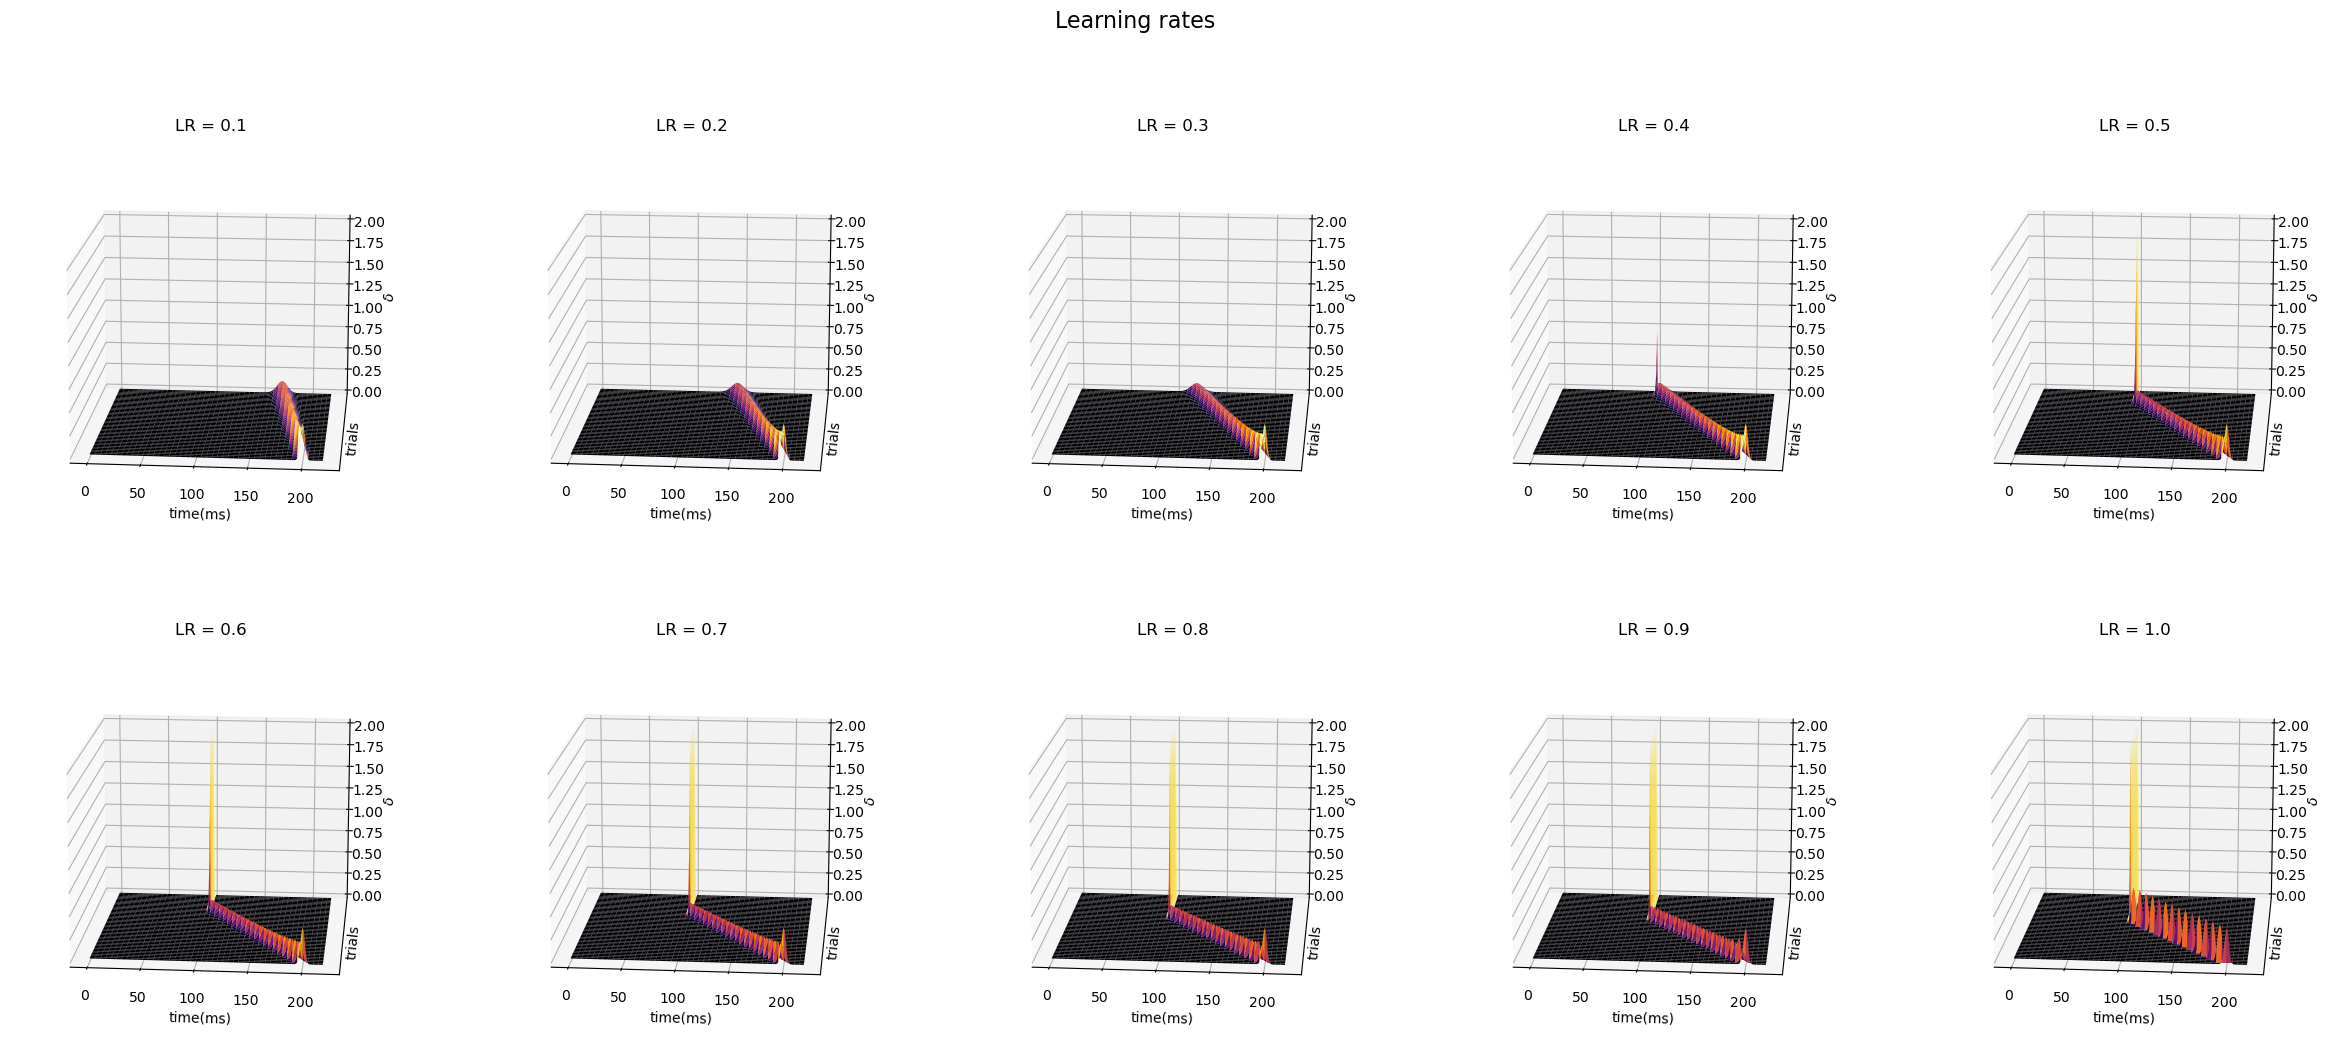

In [9]:
fig, axes = plt.subplots(2, 5, subplot_kw={"projection": "3d"}, figsize=(30,12))
fig.suptitle('Learning rates', fontsize=16)
for alphas in tqdm.tqdm(range(len(LRs))):
    ax = axes.flatten()[alphas]
    X, Y = np.meshgrid(time_vector, np.arange(0, trials))
    Z = all_delta[alphas]
    surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno)
    ax.set_xlabel("time(ms)")
    ax.set_ylabel("trials",labelpad=-15)
    ax.set_yticks([])
    ax.set_zlabel("$\delta$")
    ax.set_zlim(0, 2)
    ax.view_init(elev=15, azim=-85)
    ax.set_title(f'LR = {round(LRs[alphas],1)}')
plt.show()


In [10]:
#Multiple rewards 
two_rewards = np.zeros(len(reward))
two_rewards[150] = 2
two_rewards = gaussian_filter(two_rewards,2) + reward
alpha_s = 0.5
weights_MR = np.zeros((trials,len(time_vector))) #Reset for the next learning rate
values_MR = np.zeros(len(time_vector))
values_plot_MR = np.zeros((trials,len(time_vector)))
delta_MR = np.zeros((trials,len(time_vector)))
for i in tqdm.tqdm(range(trials)):
    for t in range(len(time_vector)-1): #Ignore the last array
        for tau in range(t):
                values_MR[t] = values_MR[t] + weights_MR[i-1,tau]*stim[t-tau]
        delta_MR[i,t] = two_rewards[t] - values_MR[t] + values_MR[t+1] #RPE
        for tau in range(t+1):
            weights_MR[i,tau] = weights_MR[i,tau] + alpha_s*delta_MR[i,t]*stim[t-tau]
    values_plot_MR[i] = values_MR


100%|██████████| 350/350 [00:29<00:00, 12.02it/s]


In [11]:
delta_v_MR = np.zeros((2, len(time_vector)-1))
delta_v_MR[0] = np.diff(values_plot_MR[0])
delta_v_MR[1] = np.diff(values_plot_MR[-1])

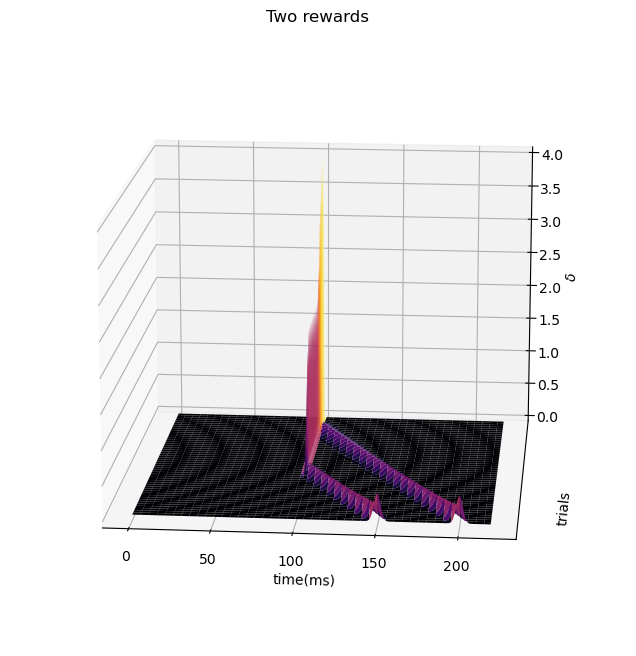

In [54]:
#Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8,8))
X = time_vector
Y = np.arange(0,trials)
X, Y = np.meshgrid(time_vector, np.arange(0, trials))
Z = delta_MR
surf = ax.plot_surface(X,Y,Z,cmap=cm.inferno)
ax.view_init(elev=15, azim=-85) 
ax.set_xlabel("time(ms)")
ax.set_ylabel("trials")
ax.set_yticks([])
ax.set_zlabel("$\delta$")
ax.set_zlim(0,4)
ax.set_title("Two rewards")
plt.show()

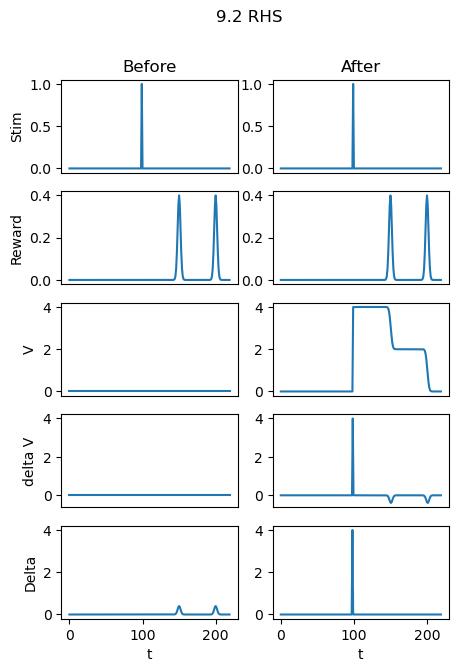

In [13]:
fig, ax = plt.subplots(5,2,figsize=(5,7))
fig.suptitle('9.2 RHS')
ax[0,0].set_title("Before")
ax[0,1].set_title("After")
ax[0,0].plot(stim)
ax[0,0].set_ylabel("Stim")
ax[0,1].plot(stim)
ax[1,0].plot(two_rewards)
ax[1,0].set_ylabel("Reward")
ax[1,1].plot(two_rewards)
ax[2,0].set_ylabel("V")
ax[2,0].plot(values_plot_MR[0])
ax[2,1].plot(values_plot_MR[-1])
ax[2,0].set_ylim(ax[2, 1].get_ylim())
ax[3,0].set_ylabel("delta V")
ax[3,0].plot(delta_v_MR[0])
ax[3,1].plot(delta_v_MR[1])
ax[3,0].set_ylim(ax[3, 1].get_ylim())
ax[4,0].set_ylabel("Delta")
ax[4,0].plot(delta_MR[0])
ax[4,0].set_xlabel("t")
ax[4,1].plot(delta_MR[-1])
ax[4,1].set_xlabel("t")
ax[4,0].set_ylim(ax[4, 1].get_ylim())
for i in range(4):
    for col in range(2):
        ax[i,col].set_xticks([])
    

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


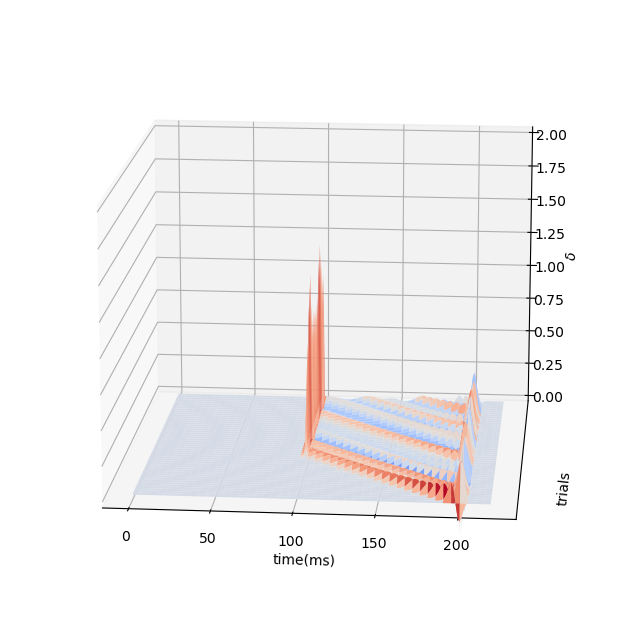

In [25]:
#Stochastic rewards
trials_s = 1000 #Delta oscillates, so I use more trials to see if it converges
weights_s = np.zeros((trials_s,len(time_vector)))
values = np.zeros(len(time_vector))
delta_s = np.zeros((trials_s,len(time_vector)))
stochastic_reward = copy.copy(reward)
alpha_s = 0.3
for i in tqdm.tqdm(range(trials_s)):
    stochastic_reward = reward if random.random() > 0.5 else np.zeros(len(stochastic_reward))
    for t in range(len(time_vector)-1): #Ignore the last array
        for tau in range(t):
                values[t] = values[t] + weights_s[i-1,tau]*stim[t-tau]
        delta_s[i,t] = stochastic_reward[t] - values[t] + values[t+1] #RPE
        for tau in range(t+1):
            weights_s[i,tau] = weights_s[i,tau] + alpha_s*delta_s[i,t]*stim[t-tau]
#Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8,8))
X = time_vector
Y = np.arange(0,trials_s)
X, Y = np.meshgrid(time_vector, np.arange(0, trials_s))
Z = delta_s
surf = ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)
ax.view_init(elev=15, azim=-85) 
ax.set_xlabel("time(ms)")
ax.set_ylabel("trials")
ax.set_yticks([])
ax.set_zlabel("$\delta$")
ax.set_zlim(0,2)
plt.show()


In [26]:
#Test with different reward probabilities
reward_p = np.linspace(0.1,0.9,9)
all_delta_s = np.zeros((len(reward_p),trials_s,len(time_vector)))
for j,rp in tqdm.tqdm(enumerate(reward_p)):
    weights_st = np.zeros((trials_s,len(time_vector))) #Reset for the next rp
    values_st = np.zeros(len(time_vector))
    delta_st = np.zeros((trials_s,len(time_vector)))
    for i in range(trials_s):
        stochastic_reward = reward if random.random() > rp else np.zeros(len(stochastic_reward))
        for t in range(len(time_vector)-1): #Ignore the last array
            for tau in range(t):
                    values_st[t] = values_st[t] + weights_st[i-1,tau]*stim[t-tau]
            delta_st[i,t] = stochastic_reward[t] - values_st[t] + values_st[t+1] #RPE
            for tau in range(t+1):
                weights_st[i,tau] = weights_st[i,tau] + alpha_s*delta_st[i,t]*stim[t-tau]
    all_delta_s[j] = delta_st



0it [00:00, ?it/s]

9it [16:48, 112.09s/it]


In [16]:
1-0.1*(6)

0.3999999999999999

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


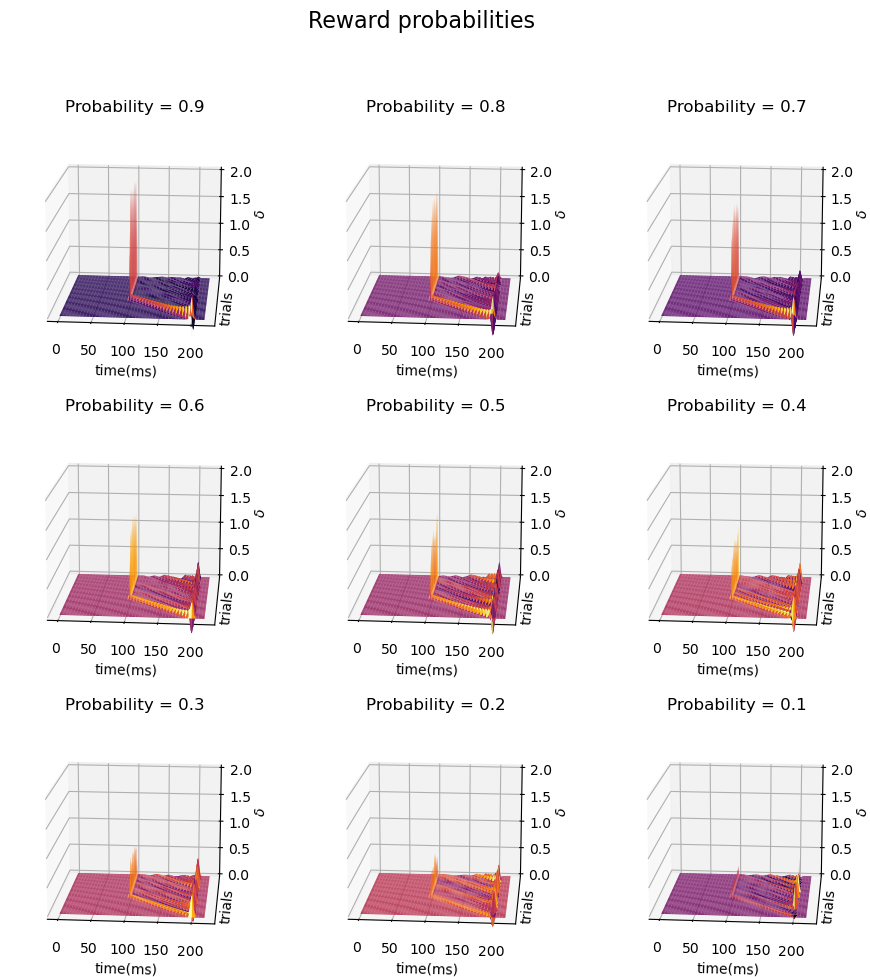

In [27]:
fig, axes = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(11,11))
fig.suptitle('Reward probabilities', fontsize=16)
for prob in tqdm.tqdm(range(len(reward_p))):
    ax = axes.flatten()[prob]
    X, Y = np.meshgrid(time_vector, np.arange(0, trials_s))
    Z = all_delta_s[prob]
    surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno)
    ax.view_init(elev=15, azim=-85)
    ax.set_xlabel("time(ms)")
    ax.set_ylabel("trials",labelpad=-15)
    ax.set_yticks([])
    ax.set_zlabel("$\delta$")
    ax.set_zlim(0, 2)
    ax.set_title(f'Probability = {round(1-0.1*(prob+1),1)}')
plt.show()

100%|██████████| 9/9 [00:00<00:00, 499.72it/s]


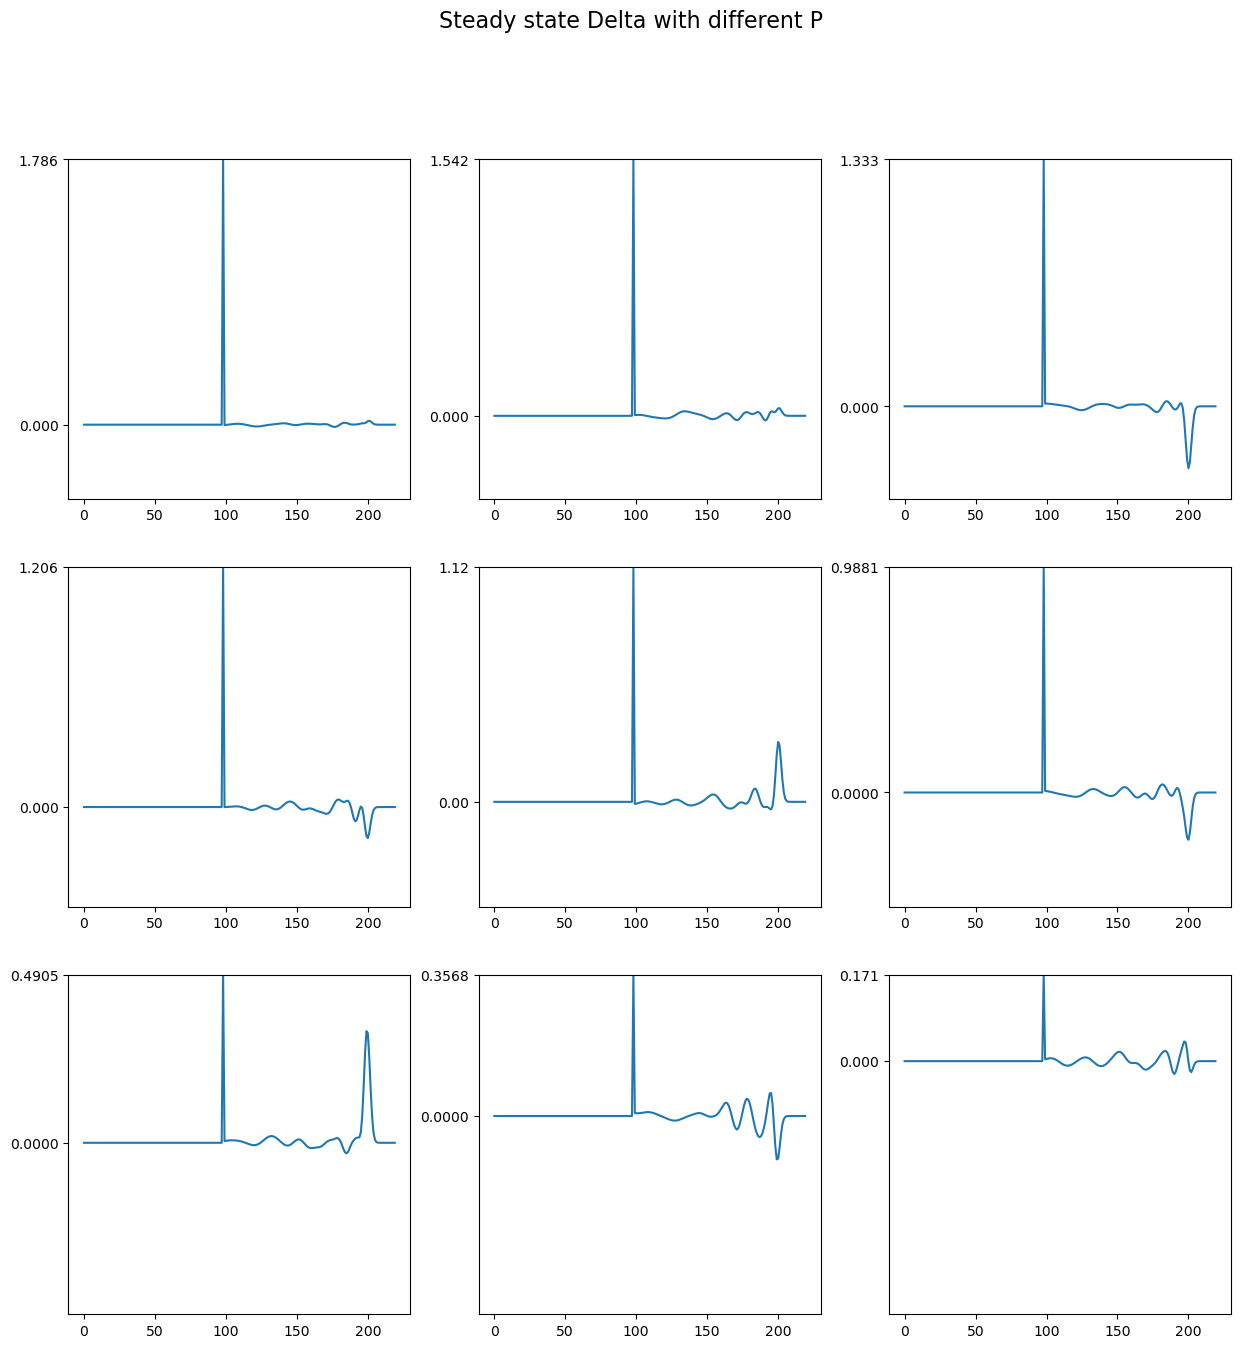

In [32]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
fig.suptitle('Steady state Delta with different P', fontsize=16)
for prob in tqdm.tqdm(range(len(reward_p))):
    ax = axes.flatten()[prob]
    ax.plot(time_vector,all_delta_s[prob,-1,:])
    ax.set_ylim(-0.5,np.max(all_delta_s[prob,-1,:]))
    ax.set_yticks([0,np.max(all_delta_s[prob,-1,:])])
